In [3]:
# build neural network
# import modelling libraries
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pickle
from PIL import Image
from torchvision import transforms
with open("64images.pickle", "rb") as f:
    data = pickle.load(f)


In [5]:
print(type(data))


<class 'list'>


In [6]:
if isinstance(data, list):
    print("Liste uzunluğu:", len(data))
    print("İlk eleman tipi:", type(data[0]))
elif isinstance(data, dict):
    print("Sözlük anahtarları:", data.keys())


Liste uzunluğu: 8855
İlk eleman tipi: <class 'numpy.ndarray'>


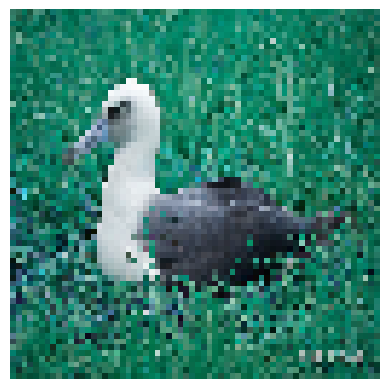

In [7]:
import numpy as np
import matplotlib.pyplot as plt



plt.imshow(data[2])
plt.axis("off")
plt.show()




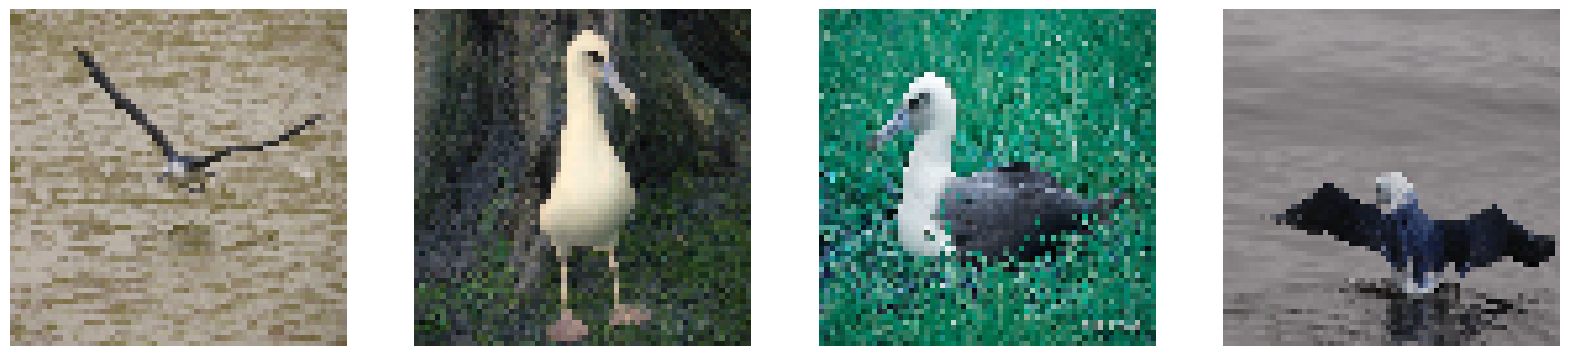

In [8]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 20))

for i in range(4):
    axs[i].imshow(data[i])
    axs[i].axis("off")   # eksenleri kapatmak istersen

plt.show()


In [9]:
data=np.array(data)
data.shape

(8855, 64, 64, 3)

In [10]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

def normalize_data(data):
    transformer = transforms.Compose([
        transforms.ToTensor(),  # 0–255 → 0–1 ve (H,W,C) → (C,H,W)
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 0–1 → -1–1
    ])

    tensor_list = []
    for img in data:
        if not isinstance(img, np.ndarray) or img.size == 0:
            continue
        if len(img.shape) != 3 or img.shape[2] not in [1, 3]:
            continue

        img = Image.fromarray(np.uint8(img))
        img = transformer(img)
        tensor_list.append(img)

    tensor_data = torch.stack(tensor_list)
    return tensor_data


# ==========================
# 🔹 Kullanım
# ==========================
data = normalize_data(data)

print("✅ Dönüştürülen görüntü sayısı:", data.shape[0])
print("Son shape:", data.shape)
print("Değer aralığı:", data.min().item(), "→", data.max().item())


✅ Dönüştürülen görüntü sayısı: 8855
Son shape: torch.Size([8855, 3, 64, 64])
Değer aralığı: -1.0 → 1.0


In [11]:
data.shape

torch.Size([8855, 3, 64, 64])

In [12]:
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10

In [13]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            # 1️⃣ Gürültü → 512 x 4x4
            nn.Linear(latent_dim, 512*4*4),
            nn.Unflatten(1, (512, 4, 4)),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # 2️⃣ 4x4 → 8x8 (512 → 256 kanal)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # 3️⃣ 8x8 → 16x16 (256 → 128 kanal)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # 4️⃣ 16x16 → 32x32 (128 → 64 kanal)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # 5️⃣ 32x32 → 64x64 (64 → 3 kanal, RGB)
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

In [14]:
generator_model = Generator(100)

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # 64x64x3 -> 32x32x64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # 32x32x64 -> 16x16x128
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # 16x16x128 -> 8x8x256
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Flatten(),
            # 8x8x256 = 16384
            nn.Linear(256*8*8, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [19]:
with open("../test/64images.pickle","rb") as f:
    test_data=pickle.load(f)
test_data=normalize_data(test_data)    

In [19]:
# Training loop
for epoch in range(num_epochs):
    g_loss_total = 0
    d_loss_total = 0
    
    for batch_idx, (real_images,) in enumerate(test_data):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # Etiketler
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # ============ Discriminator'ı eğit ============
        optimizer_d.zero_grad()
        
        # Gerçek görüntüler
        real_outputs = discriminator_model(real_images)
        d_loss_real = criterion(real_outputs, real_labels)
        
        # Sahte görüntüler
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator_model(z)
        fake_outputs = discriminator_model(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        
        # Toplam discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()
        
        # ============ Generator'ı eğit ============
        optimizer_g.zero_grad()
        
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator_model(z)
        fake_outputs = discriminator_model(fake_images)
        g_loss = criterion(fake_outputs, real_labels)
        
        g_loss.backward()
        optimizer_g.step()
        
        g_loss_total += g_loss.item()
        d_loss_total += d_loss.item()
    
    # Epoch sonuçları
    print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss_total/len(dataloader):.4f} | G Loss: {g_loss_total/len(dataloader):.4f}")
    
    # Her 2 epoch'ta bir örnek göster
    if (epoch + 1) % 2 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim).to(device)
            sample_images = generator_model(z).cpu()
            
            # Normalize'den geri dönüş: [-1,1] -> [0,1]
            sample_images = (sample_images + 1) / 2
            
            fig, axs = plt.subplots(4, 4, figsize=(10, 10))
            for i in range(16):
                ax = axs[i // 4, i % 4]
                img = sample_images[i].permute(1, 2, 0).numpy()
                ax.imshow(img)
                ax.axis('off')
            plt.suptitle(f'Epoch {epoch+1}')
            plt.tight_layout()
            plt.show()

print("✅ Eğitim tamamlandı!")

ValueError: too many values to unpack (expected 1)

In [ ]:
# DataLoader oluştur
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"✅ DataLoader hazır - Batch sayısı: {len(dataloader)}")

In [ ]:
# Optimizer'ları tanımla
optimizer_g = torch.optim.Adam(generator_model.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_d = torch.optim.Adam(discriminator_model.parameters(), lr=lr, betas=(beta1, beta2))

# Loss fonksiyonu
criterion = nn.BCELoss()

print("✅ Optimizer'lar ve loss fonksiyonu hazır")

In [ ]:
discriminator_model = Discriminator()

# Modelleri GPU'ya taşı (eğer varsa)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator_model = generator_model.to(device)
discriminator_model = discriminator_model.to(device)

print(f"✅ Kullanılan cihaz: {device}")
print(f"✅ Generator parametreleri: {sum(p.numel() for p in generator_model.parameters()):,}")
print(f"✅ Discriminator parametreleri: {sum(p.numel() for p in discriminator_model.parameters()):,}")